In [1]:
# add ASAP path to sys to locate the multiresolutionimageinterface
import sys
sys.path.append('/opt/ASAP/bin')
# required libraries
import multiresolutionimageinterface as mir
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tqdm import tqdm_notebook

In [2]:
imagePath = './data/training/center_0/patient_004_node_4.tif'
maskPath = imagePath.replace('.tif', '_mask.tif')
# Pixel coordinates
# These coordinates have tumor in patient_004_node_4
x_center = 12711
y_center = 88778
# Fixed crop size
width = 256
height = 256
# Visualization scale for plotting
scale = 50
# Sample these levels, decreasing order
downsamples = [8,4,2,1]

reader = mir.MultiResolutionImageReader()
mr_image = reader.open(imagePath)
mr_mask = reader.open(maskPath)

In [12]:
def getSamplesWithAnnotations(x_cent, y_cent):
    channels = 3
    imgs = np.zeros((len(downsamples), width, height, channels), dtype=np.int32)
    masks = np.zeros((len(downsamples), width, height, channels), dtype=np.int32)
    for i, ds_size in enumerate(downsamples):
        lev = mr_image.getBestLevelForDownSample(ds_size)
        ds = mr_image.getLevelDownsample(lev)
        imgs[i] = mr_image.getUCharPatch(int(x_cent - (ds*width/2)),
                                         int(y_cent - (ds*height/2)),
                                         width,
                                         height,
                                         lev)
        masks[i] = mr_mask.getUCharPatch(int(x_cent - (ds*width/2)),
                                         int(y_cent - (ds*height/2)),
                                         width,
                                         height,
                                         lev)
    return imgs, masks

def tumorPercentage(mask_level_0):
    area = mask_level_0.shape[0] * mask_level_0.shape[1]
    tumorPixels = 0
    channels = 3
    for p in mask_level_0.flatten():
        tumorPixels = tumorPixels + 1 if p == 1 else tumorPixels
    return tumorPixels / (area * channels)

def isTumor(mask_level_0):
    cutOffTumorPercentage = 75
    return tumorPercentage(mask_level_0) >= cutOffTumorPercentage

In [14]:
## This function is adapted from a digital pathology pipeline code of Mikko Tukiainen
def make_tissue_mask(slide, mask_level = 4, morpho=None, morpho_kernel_size=5, morpho_iter=1, median_filter=False, return_original = False): 
    ''' make tissue mask
        return tissue mask array which has tissue locations (pixel value 0 -> empty, 255 -> tissue)
    Args:
        slide (MultiResolutionImage): MultiResolutionImage slide to process
        mask_level (int): defines the level of zoom at which the mask be created (default 4)
        morpho (cv2.MORPHO): OpenCV morpho flag, Cv2.MORPHO_OPEN or Cv2.MORPHO_CLOSE (default None)
        morpho_kernel_size (int): kernel size for morphological transformation (default 5)
        morpho_iter (int): morphological transformation iterations (default=1)
        median_filtern (bool): Use median filtering to remove noise (default False)
        return_original (bool): return also the unmasked image
    '''
    
    ## Read the slide
    ds = slide.getLevelDownsample(mask_level)
    original_tissue = slide.getUCharPatch(0,
                                         0,
                                         int(slide.getDimensions()[0] / float(ds)),
                                         int(slide.getDimensions()[1] / float(ds)),
                                         mask_level)
    
    ## Determine the mask
    tissue_mask = cv2.cvtColor(np.array(original_tissue), cv2.COLOR_RGBA2RGB)
    tissue_mask = cv2.cvtColor(tissue_mask, cv2.COLOR_BGR2HSV)
    tissue_mask = tissue_mask[:, :, 1]
    _, tissue_mask = cv2.threshold(tissue_mask, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    if morpho is not None:
        kernel = np.ones((morpho_kernel_size,morpho_kernel_size), np.uint8)
        tissue_mask = cv2.morphologyEx(tissue_mask, morpho, kernel, iterations = morpho_iter)
        
    if median_filter:
        tissue_mask = cv2.medianBlur(tissue_mask, 15)
    
    tissue_mask = np.array(tissue_mask, dtype=np.uint8)

    if return_original:
        return tissue_mask, original_tissue
    else:
        return tissue_mask

In [15]:
def sample_centers(tissue_mask, mask_downscale=16, sample_side=256, focus_width_percentage=0.25, padding_percentage=0.01):
    mask_width, mask_height = tissue_mask.shape[:2]
    side = sample_side / mask_downscale
    padding_width = mask_width*padding_percentage
    padding_height = mask_height*padding_percentage
    half_focus = int(sample_side*focus_width_percentage / mask_downscale)
    sample_centers = []
    
    for i in range(int(mask_width // side)):
        for j in range(int(mask_height // side)):
            for sub_shift in [0, 0.5]:
                x = int((i+sub_shift) * side)
                y = int((j+sub_shift) * side)
                min_x = int(max(0, x - half_focus))
                max_x = int(min(x + half_focus, mask_width - 1))
                min_y = int(max(0, y - half_focus))
                max_y = int(min(y + half_focus, mask_height - 1))
                
                if(min_x < padding_width or max_x > mask_width-padding_width): continue
                if(min_y < padding_height or max_y > mask_height-padding_height): continue
                
                if(tissue_mask[min_x:max_x, min_y:max_y].sum() > 0):
                    sample_centers.append(np.array([x, y]))
                    
    # undo mask downscale to coordinates
    sample_centers = np.array(sample_centers) * mask_downscale
    return sample_centers

-------------------------------------------

# 1. Data

## 1.1 Whole slide images (WSI's) to patches

In [16]:
comparison_masks = []
comparison_mask_titles = []

otsu_mask, original_image = make_tissue_mask(mr_image, 
                                             mr_image.getBestLevelForDownSample(16), 
                                             return_original=True)
comparison_mask_titles.append('Original tissue')
comparison_masks.append(original_image)
comparison_mask_titles.append('Otsu mask\nMorphological closing (iter=2)\nMedian filter')
comparison_masks.append(make_tissue_mask(mr_image,
                                         mr_image.getBestLevelForDownSample(16), 
                                         morpho=cv2.MORPH_CLOSE,
                                         morpho_kernel_size=7,
                                         morpho_iter=2,
                                         median_filter=True))

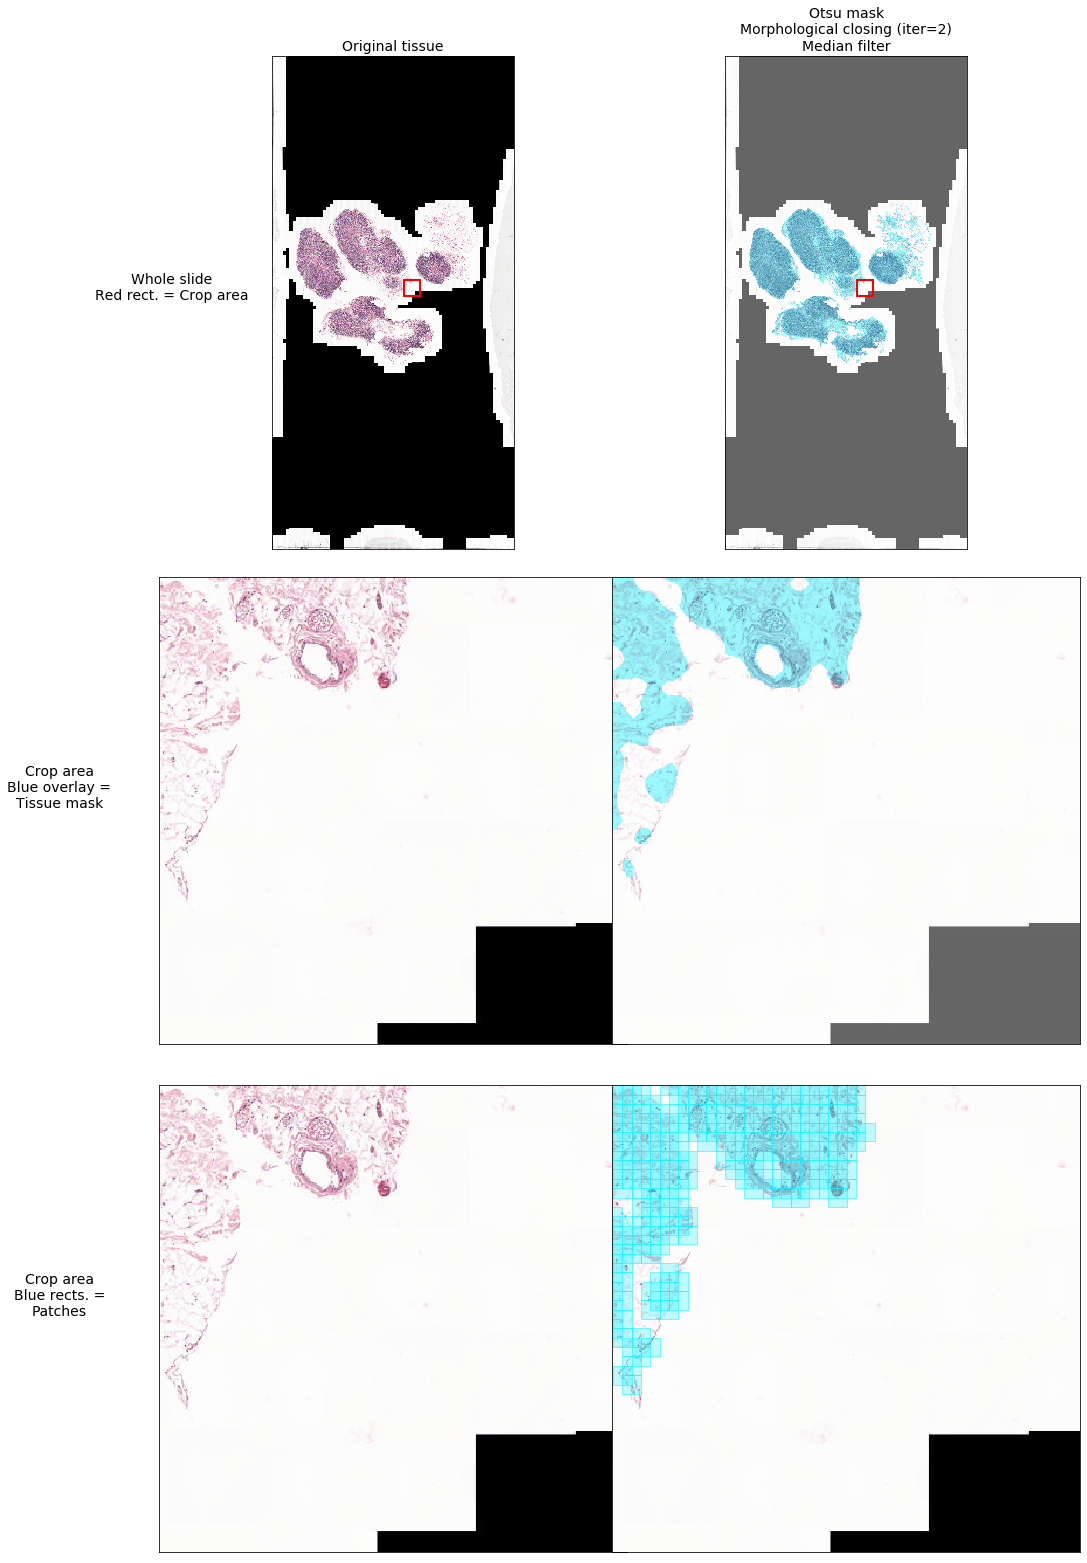

In [18]:
import matplotlib.patches as patches

# colormap for mask
from matplotlib import cm
from matplotlib.colors import ListedColormap
blues = cm.get_cmap('Blues', 256)
lightblue = blues(np.linspace(0, 1, 256))
lightblue[:100] = np.array([256/256,256/256,256/256,1])
turquoise = np.array([13/256,244/255,256/256,1])
turquoise_transparent = np.array([13/256,244/255,256/256,0.25])
lightblue[100:] = turquoise

f, ax = plt.subplots(3,len(comparison_masks),figsize=(15,22))
crop_x1 = 3300
crop_x2 = 3700
crop_y1 = 5600
crop_y2 = 6000
level_0_size = 256 / 16
fontsize_sz = 14
cmp = ListedColormap(lightblue)
alphaTissue = 1
alphaMask = 0.4

ax[0,0].imshow(comparison_masks[0], cmap=cmp)
ax[1,0].imshow(comparison_masks[0][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp)
ax[2,0].imshow(comparison_masks[0][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp)

for i in range(len(comparison_masks)):
    # draw first row
    if (i != 0):
        ax[0,i].imshow(comparison_masks[0], cmap=cmp, alpha=alphaTissue)
        ax[0,i].imshow(comparison_masks[i], cmap=cmp, alpha=alphaMask)
    ax[0,i].set_title(comparison_mask_titles[i], fontsize=fontsize_sz)
    crop_rect = patches.Rectangle((crop_x1,
                                   crop_y1),
                                  crop_x2-crop_x1,
                                  crop_y2-crop_y1,
                                  linewidth=2,
                                  edgecolor='r',
                                  facecolor='none')
    ax[0,i].add_patch(crop_rect)
    
    # draw second row
    if (i != 0):
        ax[1,i].imshow(comparison_masks[0][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp, alpha=alphaTissue)
        ax[1,i].imshow(comparison_masks[i][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp, alpha=alphaMask)
    
    # draw third row
    if (i != 0):
        sample_c_pts = sample_centers(comparison_masks[i][crop_y1:crop_y2, crop_x1:crop_x2],
                                      mask_downscale=1,
                                      sample_side=level_0_size,
                                      padding_percentage=0)
        ax[2,i].imshow(comparison_masks[0][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp, alpha=1)
        for pt in sample_c_pts:
            window_rect = patches.Rectangle((pt[1] - (level_0_size)/2,
                                             pt[0] - (level_0_size)/2),
                                            level_0_size,
                                            level_0_size,
                                            linewidth=0.5,
                                            edgecolor=turquoise,
                                            facecolor=turquoise_transparent)
            ax[2,i].add_patch(window_rect)
    
    # hide ticks
    for j in range(3):
        ax[j, i].xaxis.set_major_locator(plt.NullLocator())
        ax[j, i].yaxis.set_major_locator(plt.NullLocator())
        
ax[0,0].set_ylabel('Whole slide\nRed rect. = Crop area', fontsize=fontsize_sz, rotation=0, labelpad=100)
ax[1,0].set_ylabel('Crop area\nBlue overlay =\nTissue mask', fontsize=fontsize_sz, rotation=0, labelpad=100)
ax[2,0].set_ylabel('Crop area\nBlue rects. =\nPatches', fontsize=fontsize_sz, rotation=0, labelpad=100)
plt.tight_layout()

- WSI dimensions 100k x 200k
- Patch size 256x256
- This WSI had 61k patches
- Only around 0.3% of all the patches are annotated as tumor

## 1.2 Zoom levels

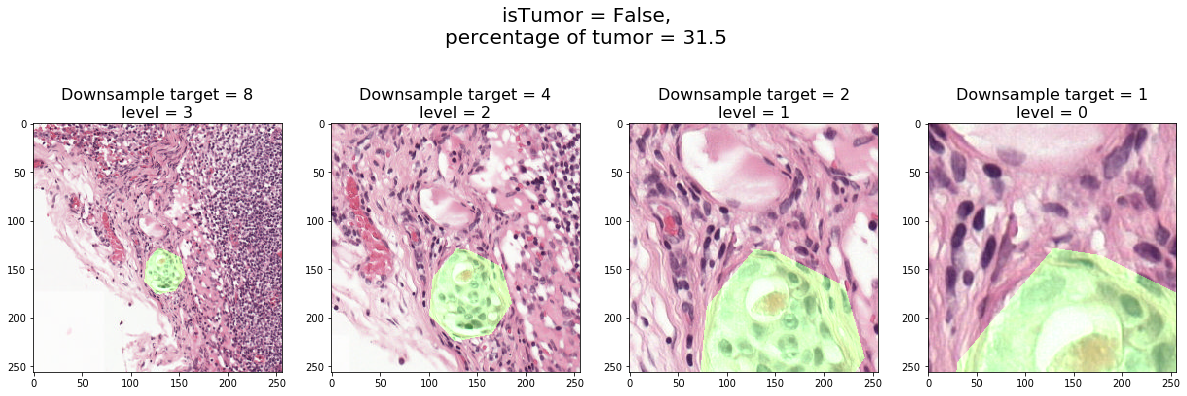

In [13]:
f, ax = plt.subplots(1,len(downsamples),figsize = (len(downsamples) * width / scale, int(1.5 * height / scale)))

imgs, masks = getSamplesWithAnnotations(x_cent=x_center,
                                        y_cent=y_center)
# check label from the lowest level
lbl = isTumor(masks[len(downsamples) - 1])
tumorPrc = tumorPercentage(masks[len(downsamples) - 1])
f.suptitle('isTumor = {0},\npercentage of tumor = {1}'.format(lbl, int(tumorPrc * 1000)/10), fontsize=20)
alpha = 0.5

for i, ds_size in enumerate(downsamples):
    level = mr_image.getBestLevelForDownSample(ds_size)
    
    # colorize
    mask_color = masks[i] * 200
    mask_color[:,:,[0,2]] = 0
    
    # create alpha channel to add to both images
    alpha_c = np.ones((mask_color.shape[0], mask_color.shape[1], 1), dtype=np.int32) * 255
    mask_color = np.concatenate([mask_color, alpha_c], axis=2)
    alpha_image = np.concatenate([imgs[i], alpha_c], axis=2)
    
    for x in range(mask_color.shape[0]):
        for y in range(mask_color.shape[1]):
            mask_color[x, y, 3] = 255 if mask_color[x, y, 2] == 1 else 0
            
    alpha_image = cv2.addWeighted(mask_color, 0.5, alpha_image, 1, 0)
    alpha_image = alpha_image.clip(min=0,max=255)
    ax[i].imshow(alpha_image)
    ax[i].set_title('Downsample target = {0}\nlevel = {1}'.format(ds_size, level), fontsize=16)

 - Green patches are tumor annotations.
 - Tumor label of this patch is `False` as the **tumor percentage is below 75%**.

## 1.3 Data selection

- 500 WSI's from five medical centers (100 WSI per center)
- Normal patches are downsampled randomly to achieve 1:1 ratio in Normal:Tumor
- Training optimization 4-fold CV where **center=fold**

| Center | Scanner | Sampled patches (normal:tumor = 1:1) | Train/Test |
|:------|:-------------|:------:|----------:|
|Center 0 (RUMC)| 3DHistech Pannoramic Flash II 250 | 25948  | Train     |
|Center 1 (CWZ)| 3DHistech Pannoramic Flash II 250 | 12084  | Train      |
|Center 2 (UMCU)| Hamamatsu NanoZoomer-XR C12000-01 | 37240  | Train      |
|Center 3 (RST)| 3DHistech Pannoramic Flash II 250 | 59438  | Train      |
|Center 4 (LPON)| Philips Ultrafast Scanner | 9186   | Test       |

> The slides from RUMC, CWZ and RST
were scanned in the RUMC with an 3DHistech P250 wholeslide scanner with a pixel size of 0.24 μm. The slides from
LPON were scanned locally with their Philips IntelliSite Ultra Fast Scanner with a 0.25 μm pixel size. The UMCU used a
Hamamatsu XR C12000 whole-slide scanner with a 0.23 μm
pixel size. [The CAMELYON17 Challenge](https://geertlitjens.nl/publication/band-18/band-18.pdf)

### 1.3.1 Color variations between the scanners (centers)

In [27]:
import pandas as pd
from PIL import Image
import random
df = pd.concat([pd.read_csv('data/training/train_val.csv'), pd.read_csv('data/training/test.csv')])

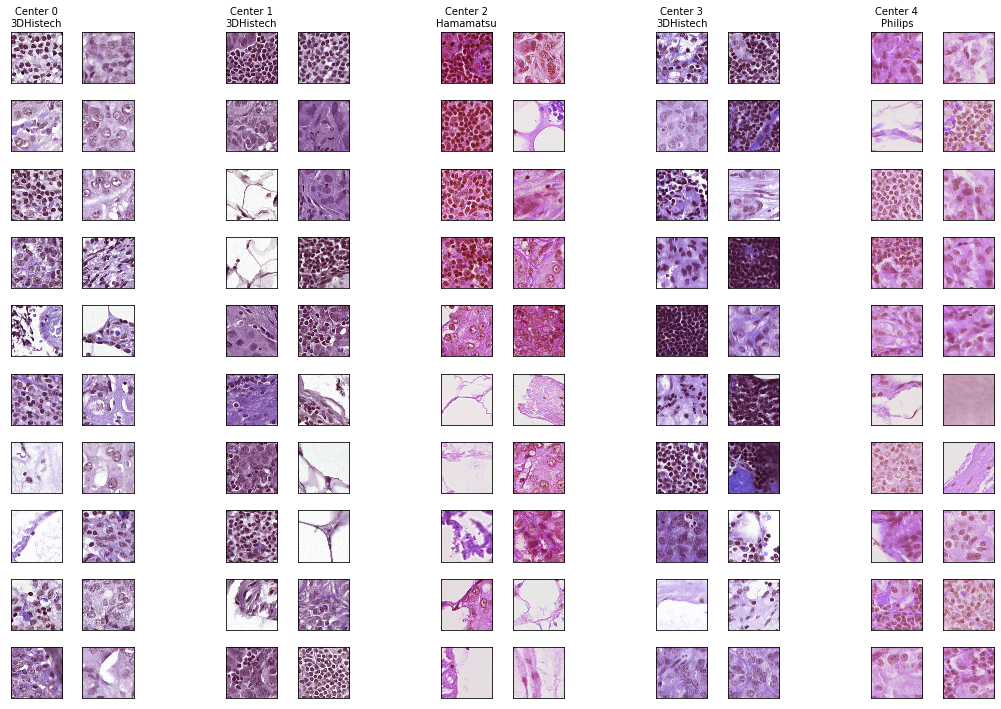

In [51]:
f, ax = plt.subplots(10,10 + 4,figsize = (14,10))
scanners = ['3DHistech', '3DHistech', 'Hamamatsu', '3DHistech', 'Philips']
for j in range(14):
    for i in range(10):
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        # leave one column space
        if j in [2,5,8,11]:
            ax[i,j].axis('off')
            continue
        df_sub = df[df.center == j//3]
        
        pth = 'data/patches/' + str(df_sub.patchId.values[random.randint(0,len(df_sub)-1)]) + '_0.png'
        ax[i,j].imshow(Image.open(pth))
        if i==0 and j in [0,3,6,9,12]:
            ax[i,j].set_title('Center ' + str(j//3) + '\n' +scanners[j//3], fontsize=10)
plt.tight_layout()

PCA - Explained variance = [0.93437388 0.06562612]


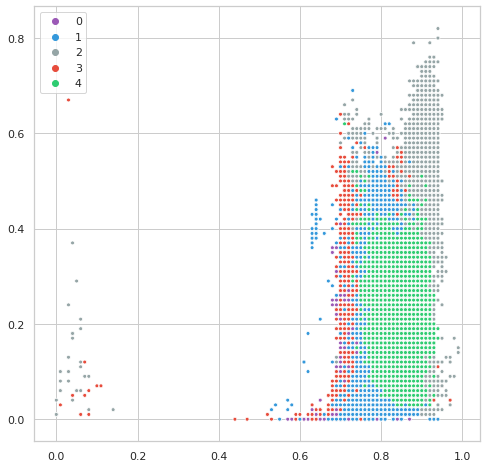

In [88]:
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('whitegrid')

X = np.array([df.meanHue.values,
             df.meanSaturation.values,
             df.meanValue.values])
pca = PCA(n_components=2)
pca.fit_transform(X)

print("PCA - Explained variance = {0}".format(pca.explained_variance_ratio_))
fig, ax = plt.subplots(figsize=(8,8))
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#2ecc71"]
sns.scatterplot(x=X[0], 
                y=X[1],
                hue=df.center.values,
                palette=sns.color_palette(flatui),
                s=15,
                ax=ax)

PCA of colors: mean hue, mean saturation & mean value per patch.

(0.65, 1)

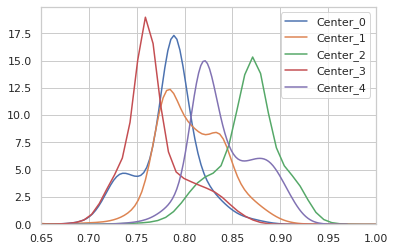

In [219]:
for n in range(5):
    sns.kdeplot(df_colors[df_colors.center == n].pca1, bw=.01, label="Center_" + str(n))
plt.xlim(0.65,1)

- we can see that the 3DHistec scanners (blue,orange and red) are all on the left side.

# 2. Model differences explained

## 2.1 Normalization
H&E histopathological staining normalization

![Normalization](img/normalization.png)

## 2.2 Multilevel model

<img src="img/multilevel_architecture_two_levels.png" alt="multilevel model" style="height: 600px;"/>

### 2.2.1 Multilevel input

<img src="img/multilevel inputs.png" alt="multilevel input" style="width: 800px;"/>

## 2.3 Autoencoder pretraining
Train the context encoder with autoencoder.

<img src="https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png" alt="multilevel input" style="width: 400px;"/>

![Autoencoder](img/autoencoder.png)

# 3. Model and parameter optimization

Leave one center out cross-validation.

- **Fold_0**: Train={`center_1`,`center_2`,`center_3`}, Validation={`center_0`}
- **Fold_1**: Train={`center_0`,`center_2`,`center_3`}, Validation={`center_1`}
- **Fold_2**: Train={`center_0`,`center_1`,`center_3`}, Validation={`center_2`}
- **Fold_3**: Train={`center_0`,`center_1`,`center_2`}, Validation={`center_3`}

### 3.1 Baseline models

|id  |Model           |Normalized |Epochs, LR (head/finetune)   |Fold_0 AUC| Fold_1 AUC| Fold_2 AUC| Fold_3 AUC | AVG AUC |
|:--:|:--------------:|:---------:|:---------------------:|:----------:|:-----------:|:-----------:|:------------:|:---------:|
|01	 |DenseNet121	  |False      |10/10 epochs, 3e-3/1e-5| 93.385   | 86.131      | 94.808      | 97.759       | 93.021    |
|02	 |DenseNet121	  |False      |8/4 epochs, 3e-3/1e-5  | 94.985   | 90.696      | 94.222      | 98.337       | 94.560    |
|03	 |DenseNet121	  |False      |4/2 epochs, 3e-3/5e-6  | 90.441   | 93.447      | **97.445**      | 97.940       | 94.818    |
|04	 |DenseNet121	  |False      |4/2 epochs, 3e-3/5e-6  | 94.514   | 95.185      | 93.049      | 96.799       | 94.886    |
|05	 |DenseNet169	  |False      |4/2 epochs, 3e-3/5e-6  | 87.867   | 93.630      | 92.140      | 97.965       | 92.901    |
|06	 |SENet154	      |False      |4/2 epochs, 3e-3/5e-6  | 93.994   | 95.950      | 94.339      | **98.651**       | 95.734    |
|07	 |InceptionResNetv2|False     |4/2 epochs, 3e-3/5e-6  | 94.609   | 96.160      | 96.321      | 98.129       | 96.305    |
|07N |InceptionResNetv2|True      |4/2 epochs, 3e-3/5e-6  | 96.156   | 96.822      | 94.862      | 96.670       | 96.128    |
|08	 |Se-ResNeXt101 32x4d|False   |4/2 epochs, 3e-3/5e-6  | 93.926   | 95.834      | 96.660      | 98.370       | 96.198    |
|08N |Se-ResNeXt101 32x4d|True    |4/2 epochs, 3e-3/5e-6  | 96.578   | **97.092**      | 94.190      | 97.351       | 96.302    |
|**10**	 |Se-ResNeXt101 32x4d|False   |1/- epoch, 1e-3/-      | 97.011   | 96.710      | 95.991      | 97.696       | **96.852**    |
|10N |Se-ResNeXt101 32x4d|True    |1/- epoch, 1e-3/-      | **98.227**   | 94.772      | 95.201      | 95.978       | 96.045    |

### 3.2 Multilevel models

|id |Model (context)|Model (focus)|Normalized|Epochs, LR (head)|Levels|Fold_0 AUC|Fold_1 AUC|Fold_2 AUC|Fold_3 AUC|AVG AUC|
|:-:|:-------------:|:-----------:|:--------:|:---------------:|:----:|:--------:|:--------:|:--------:|:--------:|:-----:|
|09	|ResNet18	    |ResNet50	  |False     |1 epoch, 3e-3    |3 & 0 | **98.780**| 93.408| 95.614| 98.479| 96.575 |
|11	|ResNet34	    |ResNet101	  |False     |1 epoch  3e-3    |3 & 0 | 98.628| 95.820| 84.971| 97.925| 94.336 |
|12N	|ResNet18	    |ResNet50	  |True      |1 epoch, 1e-3    |3 & 0 | 98.506| 97.642| 95.447| 96.226| 96.955 |
|13N	|Se-ResNeXt50	|Se-ResNeXt101|True      |1 epoch, 1e-3    |3 & 0 | 98.029| 97.393| 95.928| 97.698| 97.262 |
|14N	|Se-ResNeXt50	|Se-ResNeXt101|True      |1 epoch, 2e-3    |2 & 0 | 98.779| 97.270| 98.027| 95.648| 97.431 |
|15N	|Se-ResNeXt50	|Se-ResNeXt101|True      |1 epoch, 2e-3    |0 & 0 | 96.939| 95.904| 96.017| 95.740| 96.150 |
|16N |Se-ResNeXt50	|Se-ResNeXt101|True      |1 epoch, 2e-3, context model pretrained with autoencoder|2 & 0 | 98.510| 98.599| 98.428| 97.423| 98.240 |
|**16** |Se-ResNeXt50	|Se-ResNeXt101|False      |1 epoch, 2e-3, context model pretrained with autoencoder|2 & 0 | 98.366| **99.270**| **98.578**| **99.299**| **98.878** |
|17N |Se-ResNeXt50 + bottleneck|Se-ResNeXt101|True      |1 epoch, 2e-3  context model pretrained with autoencoder|2 & 0 | 98.767| 99.185| 96.644| 97.906| 98.125 |

In [283]:
df_baseline = pd.read_csv('results_baseline.csv', sep=";")
df_baseline.columns = ['id', 'Model', 'Normalized',
       'Epochs - LR (head/finetune)', 'Fold_0 AUC', 'Fold_1 AUC',
       'Fold_2 AUC', 'Fold_3 AUC', 'AVG AUC']
df_multilevel = pd.read_csv('results_multilevel.csv', sep=";")
df_multilevel.columns = ['id', 'Model (context)', 'Model (focus)', 'Normalized',
       'Epochs - LR (head)', 'Levels', 'Fold_0 AUC', 'Fold_1 AUC',
       'Fold_2 AUC', 'Fold_3 AUC', 'AVG AUC']
# clean text columns
df_baseline["id"]= np.char.strip(df_baseline["id"].values.astype('str'), chars='\t ')
df_baseline["Model"]= np.char.strip(df_baseline["Model"].values.astype('str'), chars='\t ')
df_baseline["Normalized"]= np.char.strip(df_baseline["Normalized"].values.astype('str'), chars='\t ')
df_multilevel["id"]= np.char.strip(df_multilevel["id"].values.astype('str'), chars='\t ')
df_multilevel["Model (context)"]= np.char.strip(df_multilevel["Model (context)"].values.astype('str'), chars='\t ')
df_multilevel["Model (focus)"]= np.char.strip(df_multilevel["Model (focus)"].values.astype('str'), chars='\t ')
df_multilevel["Normalized"]= np.char.strip(df_multilevel["Normalized"].values.astype('str'), chars='\t ')
# craft better names for plotting
df_baseline["name"] = [df_baseline.at[i,"id"] + ' - ' + df_baseline.at[i,"Model"] + (" - Norm." if df_baseline.at[i,'Normalized'] == 'True' else "") for i in range(len(df_baseline))]
df_multilevel["name"] = [df_multilevel.at[i,"id"] + ' - ' + df_multilevel.at[i,"Model (context)"] + ' - ' + df_multilevel.at[i,"Model (focus)"] + ', Lvls: ' + df_multilevel.at[i,'Levels'] +  (" - Norm." if df_multilevel.at[i,'Normalized'] == 'True' else "")for i in range(len(df_multilevel))]
df_multilevel.at[6,"name"] = df_multilevel.at[6,"name"] + ' (pretrained context)'
df_multilevel.at[7,"name"] = df_multilevel.at[7,"name"] + ' (pretrained context)'
df_multilevel.at[8,"name"] = df_multilevel.at[8,"name"] + ' (pretrained context)'

In [284]:
plot_columns = ['Fold_0 AUC', 'Fold_1 AUC','Fold_2 AUC', 'Fold_3 AUC', 'AVG AUC', 'name']
df_optim = pd.concat([df_baseline[plot_columns], df_multilevel[plot_columns]], ignore_index=True)
#df_optim

Text(0.5, 0, 'AUC')

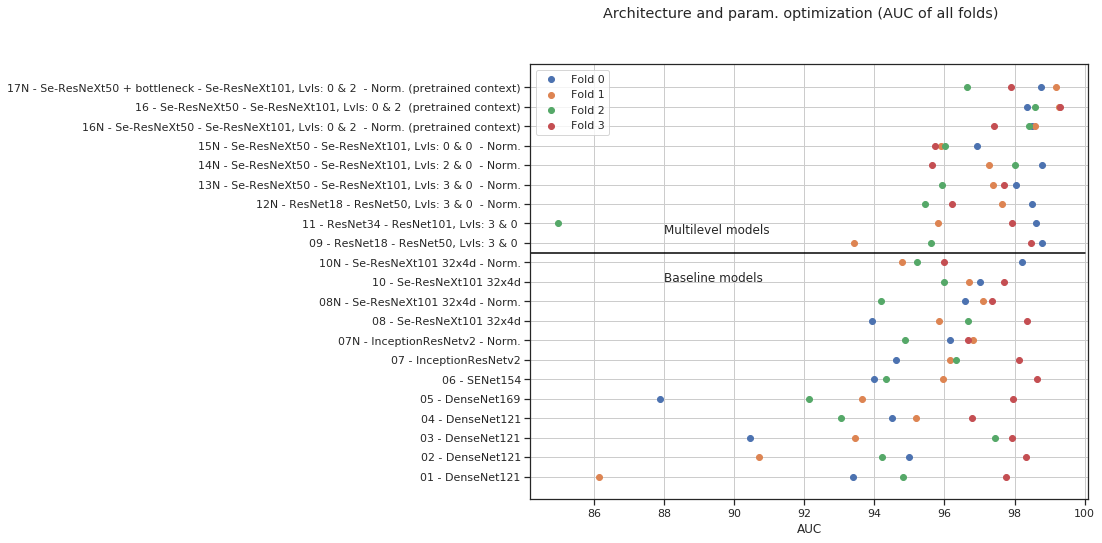

In [339]:
import matplotlib.lines as mlines
fig, ax = plt.subplots(figsize=(10,8))

plt.suptitle("Architecture and param. optimization (AUC of all folds)")

ax.scatter(df_optim['Fold_0 AUC'].values, df_optim['name'].values, label="Fold 0")
ax.scatter(df_optim['Fold_1 AUC'].values, df_optim['name'].values, label="Fold 1")
ax.scatter(df_optim['Fold_2 AUC'].values, df_optim['name'].values, label="Fold 2")
ax.scatter(df_optim['Fold_3 AUC'].values, df_optim['name'].values, label="Fold 3")
l = mlines.Line2D([0,100], [11.5,11.5], color='black')
plt.text(88, 12.5, "Multilevel models")
plt.text(88, 10.0, "Baseline models")
ax.add_line(l)
plt.grid(b=True, which='major', color='#cccccc', linestyle='-')
ax.legend()
plt.xlabel("AUC")

Text(0.5, 0, 'AUC')

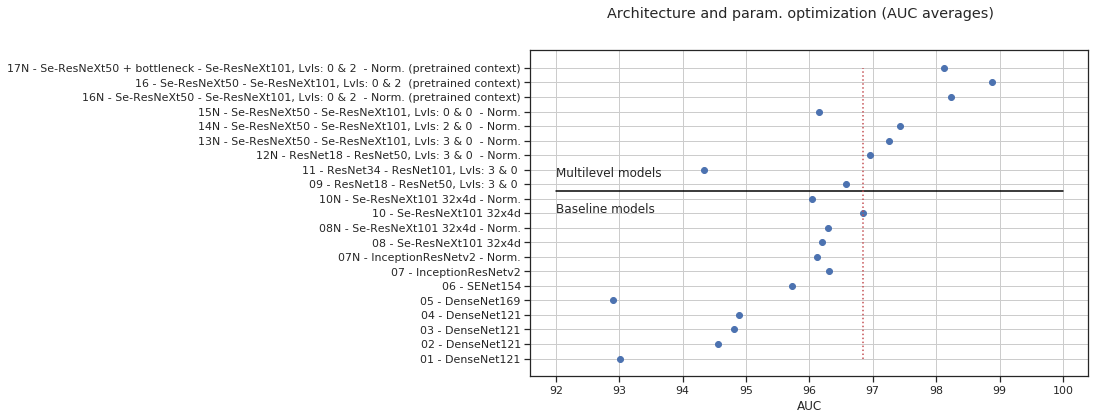

In [338]:
fig, ax = plt.subplots(figsize=(10,6))

plt.suptitle("Architecture and param. optimization (AUC averages)")

l = mlines.Line2D([92,100], [11.5,11.5], color='black')
l_baseline = mlines.Line2D([96.852,96.852], [0,20], linestyle=":", color='r')
plt.text(92, 12.5, "Multilevel models")
plt.text(92, 10.0, "Baseline models")
ax.add_line(l)
ax.add_line(l_baseline)
ax.scatter(df_optim['AVG AUC'].values, df_optim['name'].values)
plt.grid(b=True, which='major', color='#cccccc', linestyle='-')
plt.xlabel("AUC")

- Average AUCs from all of the four folds
- The red dotted line is the best baseline average AUC

Text(0.5, 0, 'AUC')

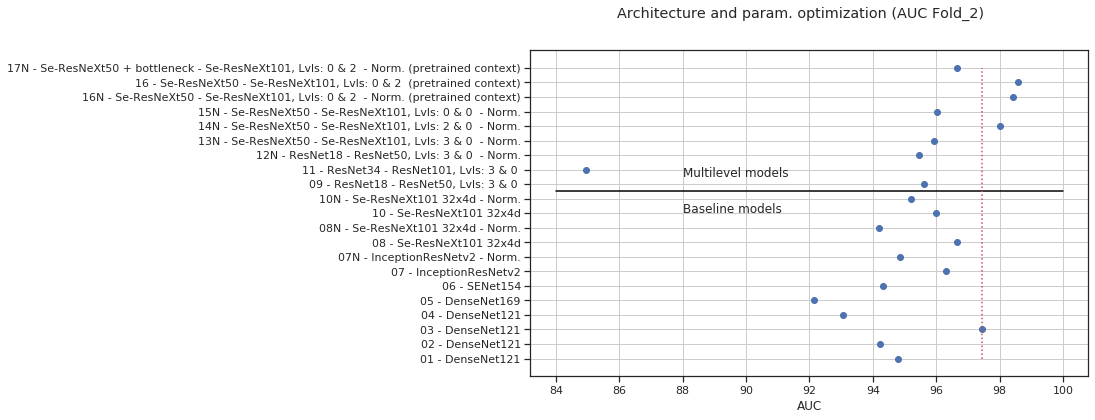

In [337]:
fig, ax = plt.subplots(figsize=(10,6))

plt.suptitle("Architecture and param. optimization (AUC Fold_2)")

l = mlines.Line2D([84,100], [11.5,11.5], color='black')
l_baseline = mlines.Line2D([97.445,97.445], [0,20], linestyle=":", color='r')
plt.text(88, 12.5, "Multilevel models")
plt.text(88, 10.0, "Baseline models")
ax.add_line(l)
ax.add_line(l_baseline)
ax.scatter(df_optim['Fold_2 AUC'].values, df_optim['name'].values)
plt.grid(b=True, which='major', color='#cccccc', linestyle='-')
plt.xlabel("AUC")

- Fold_2 trains only with 3DHistech scanner images and validates on Hamamatsu scanner images.
- This fold simulates the performance when predicting from an unseen scanner.
- The red dotted line is the best baseline AUC in the fold_2

### 3.3 Optimization CV folds - ANOVA

In [316]:
# prepare data for ANOVA - all AUCs to one column
df_f0 = df_optim[['name','Fold_0 AUC']]
df_f0.columns = ['Name', 'AUC']
df_f1 = df_optim[['name','Fold_1 AUC']]
df_f1.columns = ['Name', 'AUC']
df_f2 = df_optim[['name','Fold_2 AUC']]
df_f2.columns = ['Name', 'AUC']
df_f3 = df_optim[['name','Fold_3 AUC']]
df_f3.columns = ['Name', 'AUC']

df_optim_anova = pd.concat([df_f0,df_f1,df_f2,df_f3], ignore_index=True)

In [340]:
compare_optim_models = ['10 - Se-ResNeXt101 32x4d', 
                  '15N - Se-ResNeXt50 - Se-ResNeXt101, Lvls: 0 & 0  - Norm.',
                 '16 - Se-ResNeXt50 - Se-ResNeXt101, Lvls: 0 & 2  (pretrained context)']
print("Compare these models: {0}".format(compare_optim_models))

Compare these models: ['10 - Se-ResNeXt101 32x4d', '15N - Se-ResNeXt50 - Se-ResNeXt101, Lvls: 0 & 0  - Norm.', '16 - Se-ResNeXt50 - Se-ResNeXt101, Lvls: 0 & 2  (pretrained context)']


In [341]:
df_optim_anova_compare = pd.concat([df_optim_anova[df_optim_anova.Name == compare_optim_models[0]],
                                  df_optim_anova[df_optim_anova.Name == compare_optim_models[1]],
                                  df_optim_anova[df_optim_anova.Name == compare_optim_models[2]]])

In [342]:
import pingouin as pg
# Run the ANOVA
aov_optim = pg.anova(data=df_optim_anova_compare, dv='AUC', between='Name', detailed=True)
print(aov_optim)

   Source      SS  DF     MS       F        p-unc   np2
0    Name  16.056   2  8.028  23.681  0.000259796  0.84
1  Within   3.051   9  0.339       -            -     -


p-value is less than 0.05 and a large F-value. This strongly disagrees with the null hypothesis that all models perform equally.

Ee can test the pairwise differences using Tukey multiple comparison test. It requires that the values are normally distributed, the variances between the groups are equal, and that the observations are independent.

In [343]:
pt_optim = pg.pairwise_tukey(dv='AUC', between='Name', data=df_optim_anova_compare)
print(pt_optim)

                                                   A  \
0                           10 - Se-ResNeXt101 32x4d   
1                           10 - Se-ResNeXt101 32x4d   
2  15N - Se-ResNeXt50 - Se-ResNeXt101, Lvls: 0 & ...   

                                                   B  mean(A)   mean(B)  \
0  15N - Se-ResNeXt50 - Se-ResNeXt101, Lvls: 0 & ...   96.852  96.15000   
1  16 - Se-ResNeXt50 - Se-ResNeXt101, Lvls: 0 & 2...   96.852  98.87825   
2  16 - Se-ResNeXt50 - Se-ResNeXt101, Lvls: 0 & 2...   96.150  98.87825   

      diff     SE       tail      T   p-tukey  efsize  eftype  
0  0.70200  0.412  two-sided  1.705  0.212668   1.048  hedges  
1 -2.02625  0.412  two-sided -4.922  0.001000  -3.026  hedges  
2 -2.72825  0.412  two-sided -6.627  0.001000  -4.075  hedges  


**ANOVA and Tukey HSD conclusion**

- Multilevel model with levels 0 & 2 performs significantly better than the baseline model or the multilevel model with levels 0 & 0.
- Multilevel model with levels 0 & 0 does not perform significatnly better than the baseline model.

-----------------------------------------

# 4. Test set performance

Train={`center_0`,`center_1`,`center_2`,`center_3`}, Test={`center_4`}

### 4.1 Baseline models

|id|Model|Normalized|Epochs, LR (head)|AUC-1|AUC-2|AUC-3|AUC-4|AUC-5|AUC-AVG|
|:-:|:--:|:--------:|:---------------:|:---:|:---:|:---:|:---:|:---:|:-----:|
|10|Se-ResNeXt101 32x4d|False|1 epoch, 1e-3|95.452|96.229|96.178|95.888|95.682|95.886|
|10N|Se-ResNeXt101 32x4d|True|1 epoch, 1e-3|95.808|95.385|95.338|95.695|95.411|95.527|

### 4.2 Multilevel models

|id|Model (context)|Model (focus)|Normalized|Epochs, LR (head)|Levels|AUC-1|AUC-2|AUC-3|AUC-4|AUC-5|AUC-AVG|
|:-:|:------------:|:-----------:|:--------:|:---------------:|:----:|:---:|:---:|:---:|:---:|:---:|:-----:|
|13|Se-ResNeXt50|Se-ResNeXt101|False|1 epoch, 1e-3|3 & 0|95.221|90.160|87.946|90.378|90.332|90.807|
|13N|Se-ResNeXt50|Se-ResNeXt101|True|1 epoch, 1e-3|3 & 0|92.284|95.056|91.219|96.025|95.931|94.103|
|14|Se-ResNeXt50|Se-ResNeXt101|False|1 epoch, 2e-3|2 & 0|95.108|96.153|96.229|96.456|96.554|96.100|
|14N|Se-ResNeXt50|Se-ResNeXt101|True|1 epoch, 2e-3|2 & 0|95.622|95.848|95.948|95.865|95.440|95.745|
|15|Se-ResNeXt50|Se-ResNeXt101|False|1 epoch, 2e-3|0 & 0|94.681|94.779|94.018|94.849|94.260|94.518|
|15N|Se-ResNeXt50|Se-ResNeXt101|True|1 epoch, 2e-3|0 & 0|**96.728**|96.123|95.596|96.338|96.518|**96.261**|
|16|Se-ResNeXt50|Se-ResNeXt101|False|1 epoch, 2e-3, context model pretrained with autoencoder|2 & 0|95.543|95.445|95.059|95.078|95.857|95.396|
|16N|Se-ResNeXt50|Se-ResNeXt101|True|1 epoch, 2e-3, context model pretrained with autoencoder|2 & 0|95.376|96.361|96.365|96.506|96.367|96.195|
|17|Se-ResNeXt50 + bottleneck|Se-ResNeXt101|False|1 epoch, 2e-3  context model pretrained with autoencoder|2 & 0|96.465|95.152|95.916|93.565|93.792|94.979|
|17N|Se-ResNeXt50 + bottleneck|Se-ResNeXt101|True|1 epoch, 2e-3  context model pretrained with autoencoder|2 & 0|96.101|92.645|93.776|95.349|95.523|94.679|

In [256]:
df_test_baseline = pd.read_csv('Test_baselines.csv', sep=";")
df_test_multilevel = pd.read_csv('Test_multilevels.csv', sep=";")
# craft better names for plotting
df_test_baseline["name"] = [df_test_baseline.at[i,"id"] + " - Best baseline" + (" - Normalized" if df_test_baseline.at[i,'Normalized'] == True else "") for i in range(len(df_test_baseline))]
df_test_multilevel["name"] = [df_test_multilevel.at[i,"id"] + ' - Zoom levels: ' + df_test_multilevel.at[i,'Levels'] + (" - Normalized" if df_test_multilevel.at[i,'Normalized'] == True else "") for i in range(len(df_test_multilevel))]
df_test_multilevel.at[6,"name"] = df_test_multilevel.at[6,"name"] + ' (autoencoder pretrained context)'
df_test_multilevel.at[7,"name"] = df_test_multilevel.at[7,"name"] + ' (autoencoder pretrained context)'
df_test_multilevel.at[8,"name"] = df_test_multilevel.at[8,"name"] + ' (autoencoder pretrained bottleneck context)'
df_test_multilevel.at[9,"name"] = df_test_multilevel.at[9,"name"] + ' (autoencoder pretrained bottleneck context)'
plot_columns_test = ['AUC-1', 'AUC-2', 'AUC-3','AUC-4','AUC-5','AUC-AVG', 'name']
df_test = pd.concat([df_test_baseline[plot_columns_test], df_test_multilevel[plot_columns_test]], ignore_index=True)

Text(0.5, 0, 'AUC')

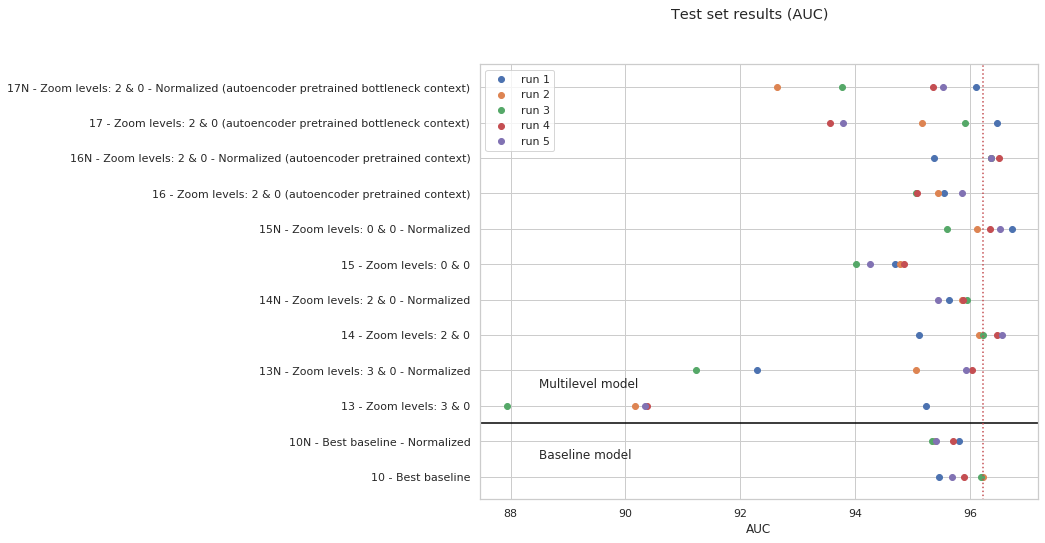

In [264]:
fig, ax = plt.subplots(figsize=(10,8))

plt.suptitle("Test set results (AUC)")

ax.scatter(df_test['AUC-1'].values, df_test['name'].values, label="run 1")
ax.scatter(df_test['AUC-2'].values, df_test['name'].values, label="run 2")
ax.scatter(df_test['AUC-3'].values, df_test['name'].values, label="run 3")
ax.scatter(df_test['AUC-4'].values, df_test['name'].values, label="run 4")
ax.scatter(df_test['AUC-5'].values, df_test['name'].values, label="run 5")
l = mlines.Line2D([0,100], [1.5,1.5], color='black')
l_baseline = mlines.Line2D([96.229,96.229], [-1,12], linestyle=":", color='r')
plt.text(88.5, 2.5, "Multilevel model")
plt.text(88.5, 0.50, "Baseline model")
ax.add_line(l)
ax.add_line(l_baseline)
ax.legend()
plt.xlabel("AUC")

- The red dotted line is the best baseline run.
- The two baseline models use SE-ResNeXt101 32x4d architecture.
- All multilevel models use SE-ResNeXt50 32x4d as the context model and SE-ResNeXt101 32x4d as the focus model.

Text(0.5, 0, 'AUC')

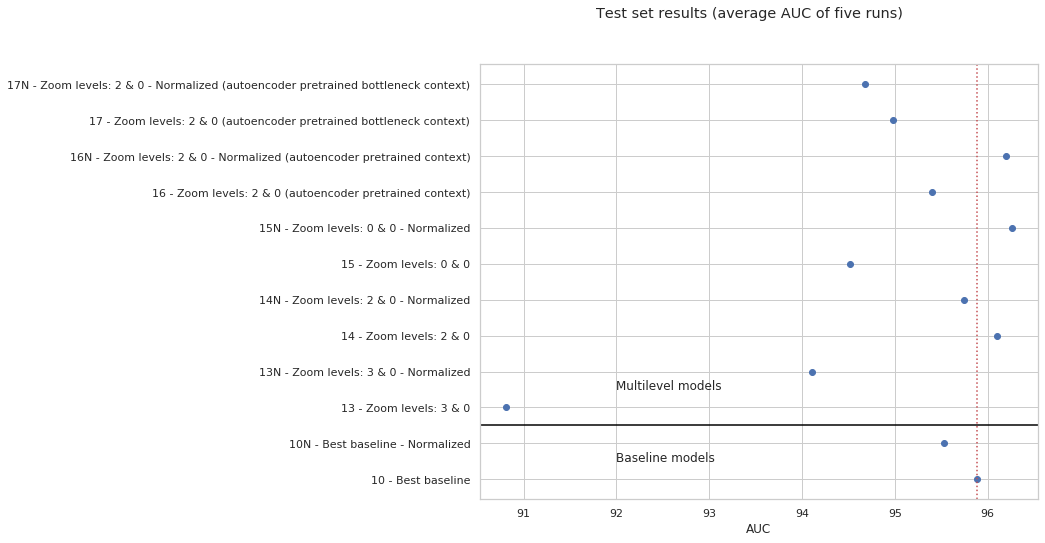

In [265]:
fig, ax = plt.subplots(figsize=(10,8))

plt.suptitle("Test set results (average AUC of five runs)")

ax.scatter(df_test['AUC-AVG'].values, df_test['name'].values)
l = mlines.Line2D([0,100], [1.5,1.5], color='black')
l_baseline = mlines.Line2D([95.886,95.886], [-1,12], linestyle=":", color='r')
plt.text(92, 2.5, "Multilevel models")
plt.text(92, 0.5, "Baseline models")
ax.add_line(l)
ax.add_line(l_baseline)
plt.xlabel("AUC")

- The red dotted line is the best average baseline AUC 

### 4.2.1 One-way ANOVA

Test null hypothesis that the test scores of all models have equal means.

μ1=μ2=...=μn

In [296]:
# prepare data for ANOVA - all AUCs to one column
df_1 = df_test[['name','AUC-1']]
df_1.columns = ['Name', 'AUC']
df_2 = df_test[['name','AUC-2']]
df_2.columns = ['Name', 'AUC']
df_3 = df_test[['name','AUC-3']]
df_3.columns = ['Name', 'AUC']
df_4 = df_test[['name','AUC-4']]
df_4.columns = ['Name', 'AUC']
df_5 = df_test[['name','AUC-5']]
df_5.columns = ['Name', 'AUC']
df_test_anova = pd.concat([df_1,df_2,df_3,df_4,df_5], ignore_index=True)

In [304]:
compare_models = ['10 - Best baseline', 
                  '16N - Zoom levels: 2 & 0 - Normalized (autoencoder pretrained context)',
                 '15N - Zoom levels: 0 & 0 - Normalized']
print("Compare these models: {0}".format(compare_models))

Compare these models: ['10 - Best baseline', '16N - Zoom levels: 2 & 0 - Normalized (autoencoder pretrained context)', '15N - Zoom levels: 0 & 0 - Normalized']


In [311]:
df_test_anova_compare = pd.concat([df_test_anova[df_test_anova.Name == compare_models[0]],
                                  df_test_anova[df_test_anova.Name == compare_models[1]],
                                  df_test_anova[df_test_anova.Name == compare_models[2]]])

In [312]:
import pingouin as pg
# Run the ANOVA
aov = pg.anova(data=df_test_anova_compare, dv='AUC', between='Name', detailed=True)
print(aov)

   Source     SS  DF    MS     F     p-unc    np2
0    Name  0.401   2  0.20  1.18  0.340633  0.164
1  Within  2.038  12  0.17     -         -      -


p-value is not less than 0.05 and F-value only slightly over one. This doesn't strongly disagree with the null hypothesis.

Although there aren't significantly different models in the comparison set, out of curiosity, we can test the pairwise differences using Tukey multiple comparison test. It requires that the values are normally distributed, the variances between the groups are equal, and that the observations are independent.

In [313]:
pt = pg.pairwise_tukey(dv='AUC', between='Name', data=df_test_anova_compare)
print(pt)

                                       A  \
0                     10 - Best baseline   
1                     10 - Best baseline   
2  15N - Zoom levels: 0 & 0 - Normalized   

                                                   B  mean(A)  mean(B)  \
0              15N - Zoom levels: 0 & 0 - Normalized  95.8858  96.2606   
1  16N - Zoom levels: 2 & 0 - Normalized (autoenc...  95.8858  96.1950   
2  16N - Zoom levels: 2 & 0 - Normalized (autoenc...  96.2606  96.1950   

     diff     SE       tail      T   p-tukey  efsize  eftype  
0 -0.3748  0.261  two-sided -1.437  0.326034  -0.821  hedges  
1 -0.3092  0.261  two-sided -1.186  0.463294  -0.677  hedges  
2  0.0656  0.261  two-sided  0.252  0.900000   0.144  hedges  


None of the compared model pairs are significantly different from each other.
**Hence, multilevel models did not perform significantly better in the test set.**